In [ ]:
import os

from jax.tree_util import tree_map

import matplotlib.pyplot as plt

import numpy as np

from vraie_vie.create_dataset import WMH

In [ ]:
config = {
    "modality": "FLAIR",
    "slice_size_template": 91,
    "flair_template_path": "/Users/geoffroyoudoumanessah/Documents/these/projects/datasets/WMH/MNI-FLAIR-2.0mm.nii.gz",
    "path_dataset": "/Users/geoffroyoudoumanessah/Documents/these/projects/datasets/WMH",
    "batch_size": 32,
    "num_workers": 0,
}

wmh = WMH(config)
wmh.setup()

train_loader = wmh.get_train_dataloader()

In [ ]:
for x in train_loader:
    break

print(x.shape)
plt.imshow(x[0, ..., 0], cmap="gray")
plt.imshow(x[0, ..., 1].astype(np.uint8), cmap="Reds", alpha=0.5)
plt.show()

# Train

In [29]:
from functools import partial

import jax
import jax.numpy as jnp

import optax

from vraie_vie.create_dataset import WMH

from diffuse.score_matching import score_match_loss
from diffuse.sde import SDE, SDEState, LinearSchedule
from diffuse.unet import UNet

import numpy as np

import os

import sys
from tqdm import tqdm

In [15]:
def step(key, params, opt_state, ema_state, data, optimizer, ema_kernel, sde, cfg):
    val_loss, g = jax.value_and_grad(loss)(
        params, key, data, sde, cfg["n_t"], cfg["tf"]
    )
    updates, opt_state = optimizer.update(g, opt_state)
    params = optax.apply_updates(params, updates)
    ema_params, ema_state = ema_kernel.update(params, ema_state)
    return params, opt_state, ema_state, val_loss, ema_params


def weight_fun(t):
    int_b = sde.beta.integrate(t, 0).squeeze()
    return 1 - jnp.exp(-int_b)

In [20]:
config = {
    "modality": "FLAIR",
    "slice_size_template": 91,
    "path_dataset": "/lustre/fswork/projects/rech/hlp/uha64uw/aistat24/WMH",
    "n_epochs": 10,
    "batch_size": 32,
    "num_workers": 0,
    "n_t": 32,
    "tf": 2.0,
    "lr": 2e-4,
}

In [21]:
wmh = WMH(config)
wmh.setup()
train_loader = wmh.get_train_dataloader()

In [22]:
key = jax.random.PRNGKey(0)

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta)


nn_unet = UNet(config["tf"] / config["n_t"], 64, upsampling="pixel_shuffle")

init_params = nn_unet.init(
    key,
    jnp.ones((config["batch_size"], *train_loader.dataset[0].shape)),
    jnp.ones((config["batch_size"],)),
)

loss = partial(score_match_loss, lmbda=jax.vmap(weight_fun), network=nn_unet)


until_steps = int(0.95 * config["n_epochs"]) * len(train_loader)
schedule = optax.cosine_decay_schedule(
    init_value=config["lr"], decay_steps=until_steps, alpha=1e-2
)

optimizer = optax.adam(learning_rate=schedule)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optimizer)
ema_kernel = optax.ema(0.99)

batch_update = jax.jit(
    partial(step, optimizer=optimizer, ema_kernel=ema_kernel, sde=sde, cfg=config)
)

params = init_params
opt_state = optimizer.init(params)
ema_state = ema_kernel.init(params)

In [23]:
iterator = tqdm(train_loader, desc="Training", file=sys.stdout)

for batch in iterator:
    key, subkey = jax.random.split(key)
    params, opt_state, ema_state, val_loss, ema_params = batch_update(
        subkey, params, opt_state, ema_state, batch
    )

    iterator.set_postfix({"loss": val_loss})

Training: 100%|██████████| 173/173 [07:57<00:00,  2.76s/it, loss=0.03283871] 


In [24]:
def nn_score(x, t):
    return nn_unet.apply(params, x, t)

In [40]:
n_steps = 5000
rng_key = jax.random.PRNGKey(0)

ts = jnp.array([config["tf"]])
dts = jnp.array([2.0 / n_steps] * (n_steps))

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta=beta)

init_samples = jax.random.normal(rng_key, batch[0].shape)
state_f = SDEState(position=init_samples, t=ts)

revert_sde = partial(sde.reverso, score=nn_score, dts=dts)
state_0, state_Ts = revert_sde(rng_key, state_f)

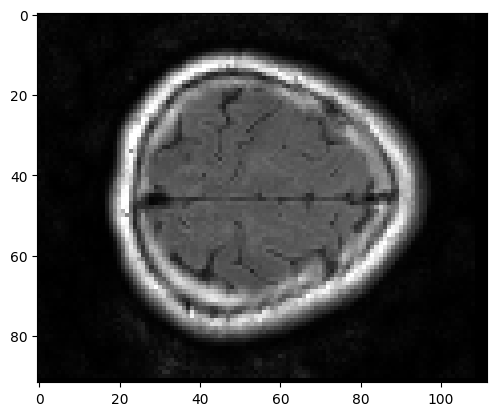

In [46]:
plt.imshow(batch[20, ..., 0], cmap="gray")

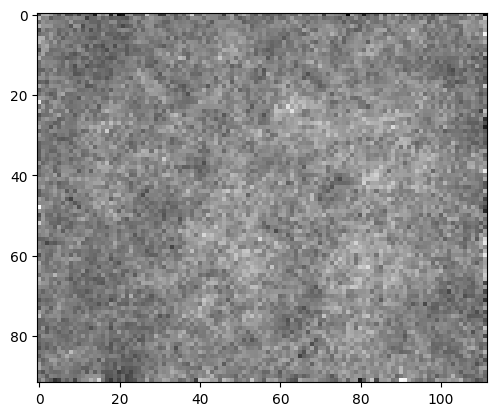

In [41]:
import matplotlib.pyplot as plt

plt.imshow(state_Ts.position[-1][..., 0], cmap="gray")
plt.show()